# EDA and Visualization

In this notebook, we will be performing exploratory data analysis and visualization on the cleaned dataset. We will be focusing on three fields in the dataset: Weather, Engine Count/Type, and Amateur Built.

But first, let's import our cleaned dataset:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./data/AviationData_clean.csv', index_col=0)

df.head(5)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Aircraft.damage,Registration.Number,Make,Model,...,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Location_City,Location_State
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,Destroyed,NC6404,Stinson,108-3,...,Reciprocating,Personal,2.0,0.0,0.0,0.0,UNK,Cruise,Moose Creek,ID
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,Destroyed,N5069P,Piper,PA24-180,...,Reciprocating,Personal,4.0,0.0,0.0,0.0,UNK,Unknown,Bridgeport,CA
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,Destroyed,N5142R,Cessna,172M,...,Reciprocating,Personal,3.0,0.0,0.0,0.0,IMC,Cruise,Saltville,VA
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,Destroyed,N1168J,Rockwell,112,...,Reciprocating,Personal,2.0,0.0,0.0,0.0,IMC,Cruise,Eureka,CA
5,20170710X52551,Accident,NYC79AA106,1979-09-17,"BOSTON, MA",United States,Substantial,CF-TLU,Mcdonnell Douglas,DC9,...,Turbo Fan,Unknown,0.0,0.0,1.0,44.0,VMC,Climb,Boston,MA


## Weather

In this section, we will be examining the Weather field of the dataset. We will compare the five most common aircraft manufacturers in the dataset to try to determine which one is the safest during inclement weather.

### EDA

First, we'll make a copy of the dataframe from the default that we imported to work with. We'll also only look at events from 2002 or later, as those aircraft are still in use today.

In [2]:
weather_df = df.copy()
weather_df['Event.Date'] = pd.to_datetime(weather_df['Event.Date'])
weather_df = weather_df[weather_df['Event.Date'].dt.year >= 2002]
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29947 entries, 51959 to 88767
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.Id                29947 non-null  object        
 1   Investigation.Type      29947 non-null  object        
 2   Accident.Number         29947 non-null  object        
 3   Event.Date              29947 non-null  datetime64[ns]
 4   Location                29947 non-null  object        
 5   Country                 29946 non-null  object        
 6   Aircraft.damage         29947 non-null  object        
 7   Registration.Number     29947 non-null  object        
 8   Make                    29947 non-null  object        
 9   Model                   29947 non-null  object        
 10  Amateur.Built           29947 non-null  object        
 11  Number.of.Engines       29947 non-null  float64       
 12  Engine.Type             29947 non-null  object 

Now we'll look at the possible weather condition values present in the dataset.

In [3]:
weather_df['Weather.Condition'].value_counts()

Weather.Condition
VMC    28210
IMC     1572
UNK      165
Name: count, dtype: int64

There are 3 different weather conditions:
- **VMC:** short for Visual Meteorological Conditions, weather conditions that allow a pilot to navigate by visual reference to the ground and other landmarks (i.e. clear weather).
- **IMC:** short for Instrument Meteorological Conditions, weather conditions that require a pilot to rely on flight instruments (i.e. stormy or very cloudy weather).
- **UNK:** short for Unknown, weather data was not present in the report.

For this report, we will only be focusing on VMC and IMC values.

Now, let's look at the top 5 most common aircraft manufacturers in our dataset. We'll by grouping the dataframe by Make and creating a list of the first 5 values when we sort the value counts of the Event.Id field for each Make. Then, we'll make a new dataframe that only includes those top 5 manufacturers.

In [4]:
make_list = list(weather_df.groupby('Make')['Event.Id'].count().sort_values(ascending=False).head(5).index)
top5_df = weather_df[weather_df['Make'].isin(make_list)]
top5_df['Make'].value_counts()

Make
Cessna    8108
Piper     4578
Beech     1680
Bell       799
Boeing     575
Name: count, dtype: int64

Next, we'll filter the dataset to remove the UNK weather condition.

In [5]:
top5_weather_df = top5_df[(top5_df['Weather.Condition'] == 'IMC') | (top5_df['Weather.Condition'] == 'VMC')]

Let's take a look at the number of incidents when we sort the data by Weather Condition and Make

In [6]:
top5_weather_df_grouped = top5_weather_df.groupby(['Weather.Condition', 'Make'])
top5_weather_df_grouped['Event.Id'].count().sort_values(ascending=False)

Weather.Condition  Make  
VMC                Cessna    7646
                   Piper     4250
                   Beech     1470
                   Bell       772
                   Boeing     504
IMC                Cessna     430
                   Piper      306
                   Beech      204
                   Boeing      43
                   Bell        24
Name: Event.Id, dtype: int64

The Makes with the most incidents are Cessna, Piper, and Beech. Now, we'll look at the average and sum of the Total.Fatal.Injuries field to determine which Make is the most dangerous.

In [7]:
top5_weather_df_grouped[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries']].agg(['mean', 'sum'])['Total.Fatal.Injuries'].sort_values(by=('mean'), ascending=False)

mean     sum
Weather.Condition Make                    
IMC               Bell    1.958333    47.0
                  Piper   1.467320   449.0
                  Beech   1.392157   284.0
                  Cessna  1.318605   567.0
VMC               Beech   0.509524   749.0
                  Bell    0.317358   245.0
                  Piper   0.293647  1248.0
                  Boeing  0.289683   146.0
                  Cessna  0.228878  1750.0
IMC               Boeing  0.093023     4.0

Our takeaway here is that in inclement weather, Bell has the most average fatalities while Boeing has the least. In clear weather, Beech has the most and Cessna has the least.

### Visualization

We will make a bar chart comparing the average fatalities of our sample of 5 Makes in the 2 different weather conditions.

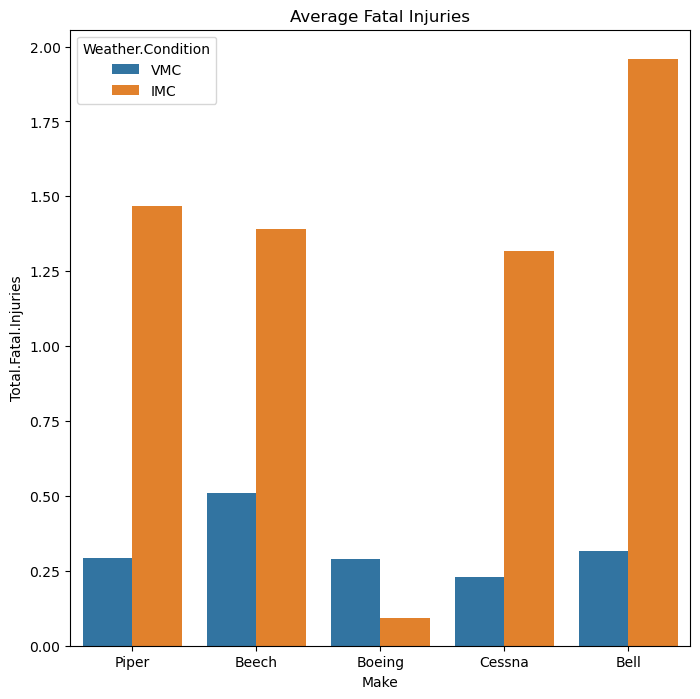

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(data=top5_weather_df, x='Make', y='Total.Fatal.Injuries', estimator='mean', hue='Weather.Condition', errorbar=None, ax=ax)

ax.set_title('Average Fatal Injuries')

plt.show()

It is apparent here that overall, Boeing is the safest in inclement weather by far. So, if our company was looking to purchase an aircraft for use in inclement weather, Boeing is the best choice.

## Engine Count/Type

## Amateur Made

In this section, we will be comparing the 5 most common amateur manufacturers to the 5 most common professional manufacturers.

### EDA

Let's make a copy of the original dataframe and only include events from 2002 and later.

In [9]:
amateur_made_df = df.copy()
amateur_made_df['Event.Date'] = pd.to_datetime(amateur_made_df['Event.Date'])
amateur_made_df = amateur_made_df[amateur_made_df['Event.Date'].dt.year >= 2002]
amateur_made_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29947 entries, 51959 to 88767
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.Id                29947 non-null  object        
 1   Investigation.Type      29947 non-null  object        
 2   Accident.Number         29947 non-null  object        
 3   Event.Date              29947 non-null  datetime64[ns]
 4   Location                29947 non-null  object        
 5   Country                 29946 non-null  object        
 6   Aircraft.damage         29947 non-null  object        
 7   Registration.Number     29947 non-null  object        
 8   Make                    29947 non-null  object        
 9   Model                   29947 non-null  object        
 10  Amateur.Built           29947 non-null  object        
 11  Number.of.Engines       29947 non-null  float64       
 12  Engine.Type             29947 non-null  object 

Next, let's make a dataframe for amateur made and professional made aircraft. Then, we'll make lists of the top 5 most common Makes in each category.

In [10]:
amateur_df = amateur_made_df[amateur_made_df['Amateur.Built'] == 'Yes']
not_amateur_df = amateur_made_df[amateur_made_df['Amateur.Built'] == 'No']

In [11]:
top5_amateur_list = list(amateur_df.groupby('Make')['Event.Id'].count().sort_values(ascending=False).head(5).index)
top5_not_amateur_list = list(not_amateur_df.groupby('Make')['Event.Id'].count().sort_values(ascending=False).head(5).index)
print(top5_amateur_list)
print(top5_not_amateur_list)

['Vans', 'Zenith', 'Lancair', 'Rans', 'Rotorway']
['Cessna', 'Piper', 'Beech', 'Bell', 'Boeing']


We'll make two next dataframes back on the two top 5 lists that we made

In [12]:
top5_amateur_df = amateur_df[amateur_df['Make'].isin(top5_amateur_list)]
top5_amateur_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 52823 to 88366
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.Id                169 non-null    object        
 1   Investigation.Type      169 non-null    object        
 2   Accident.Number         169 non-null    object        
 3   Event.Date              169 non-null    datetime64[ns]
 4   Location                169 non-null    object        
 5   Country                 169 non-null    object        
 6   Aircraft.damage         169 non-null    object        
 7   Registration.Number     169 non-null    object        
 8   Make                    169 non-null    object        
 9   Model                   169 non-null    object        
 10  Amateur.Built           169 non-null    object        
 11  Number.of.Engines       169 non-null    float64       
 12  Engine.Type             169 non-null    object   

In [13]:
top5_not_amateur_df = not_amateur_df[not_amateur_df['Make'].isin(top5_not_amateur_list)]
top5_not_amateur_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15737 entries, 51959 to 88661
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.Id                15737 non-null  object        
 1   Investigation.Type      15737 non-null  object        
 2   Accident.Number         15737 non-null  object        
 3   Event.Date              15737 non-null  datetime64[ns]
 4   Location                15737 non-null  object        
 5   Country                 15737 non-null  object        
 6   Aircraft.damage         15737 non-null  object        
 7   Registration.Number     15737 non-null  object        
 8   Make                    15737 non-null  object        
 9   Model                   15737 non-null  object        
 10  Amateur.Built           15737 non-null  object        
 11  Number.of.Engines       15737 non-null  float64       
 12  Engine.Type             15737 non-null  object 

Let's take a look at the average number of fatalities in the amateur adn professional dataframes.

In [14]:
top5_amateur_df.groupby('Make')['Total.Fatal.Injuries'].agg('mean').sort_values(ascending=False)

Make
Lancair     0.375000
Vans        0.368421
Rans        0.363636
Zenith      0.200000
Rotorway    0.045455
Name: Total.Fatal.Injuries, dtype: float64

In [15]:
top5_not_amateur_df.groupby('Make')['Total.Fatal.Injuries'].agg('mean').sort_values(ascending=False)

Make
Beech     0.620012
Piper     0.378059
Bell      0.370463
Cessna    0.291441
Boeing    0.260870
Name: Total.Fatal.Injuries, dtype: float64

### Visualization

Now, we'll graph our findings from above.

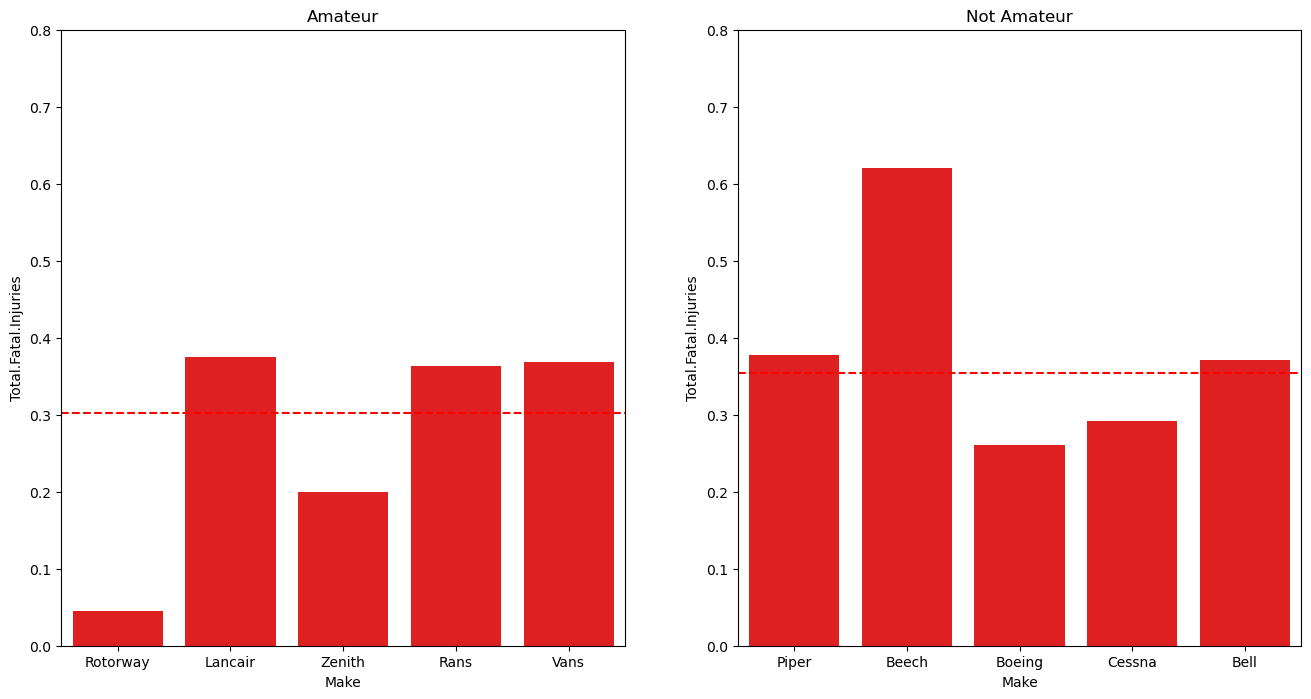

In [16]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

sns.barplot(data=top5_amateur_df, orient='v', x='Make', y='Total.Fatal.Injuries', errorbar=None, estimator='mean', color='red', ax=ax[0])
sns.barplot(data=top5_not_amateur_df, orient='v', x='Make', y='Total.Fatal.Injuries', errorbar=None, estimator='mean', color='red', ax=ax[1])

ax[0].set_ylim(0,.8)
ax[0].set_title('Amateur')
ax[0].axhline(y=top5_amateur_df['Total.Fatal.Injuries'].mean(), color='red', ls='--')

ax[1].set_ylim(0,.8)
ax[1].set_title('Not Amateur')
ax[1].axhline(y=top5_not_amateur_df['Total.Fatal.Injuries'].mean(), color='red', ls='--')

plt.show()

Here, you can see that the average fatalities are higher for professional made aircraft than amateur made. Rotorway has the least average fatalities for amateur while Boeing has the least for professional.

For good measure, let's look at the average Serious Injuries and Minor Injuries:

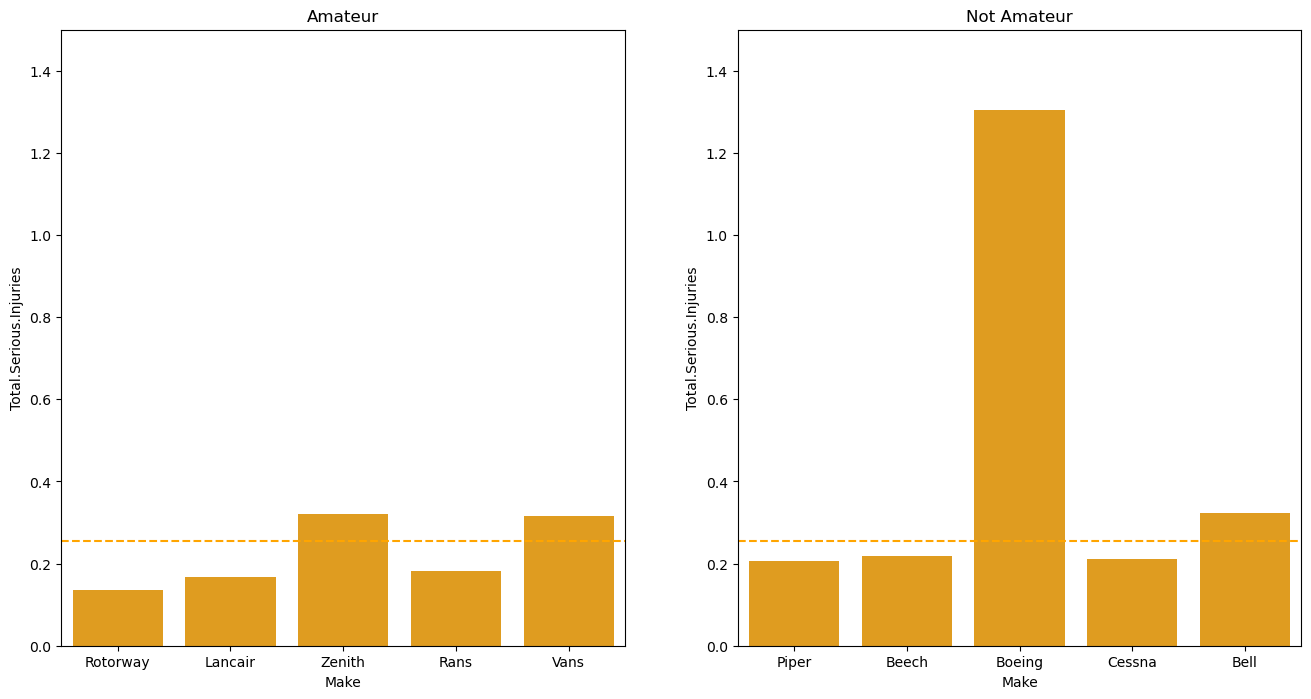

In [17]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

sns.barplot(data=top5_amateur_df, orient='v', x='Make', y='Total.Serious.Injuries', errorbar=None, estimator='mean', color='orange', ax=ax[0])
sns.barplot(data=top5_not_amateur_df, orient='v', x='Make', y='Total.Serious.Injuries', errorbar=None, estimator='mean', color='orange', ax=ax[1])

ax[0].set_ylim(0,1.5)
ax[0].set_title('Amateur')
ax[0].axhline(y=top5_amateur_df['Total.Serious.Injuries'].mean(), color='orange', ls='--')

ax[1].set_ylim(0,1.5)
ax[1].set_title('Not Amateur')
ax[1].axhline(y=top5_not_amateur_df['Total.Serious.Injuries'].mean(), color='orange', ls='--')

plt.show()

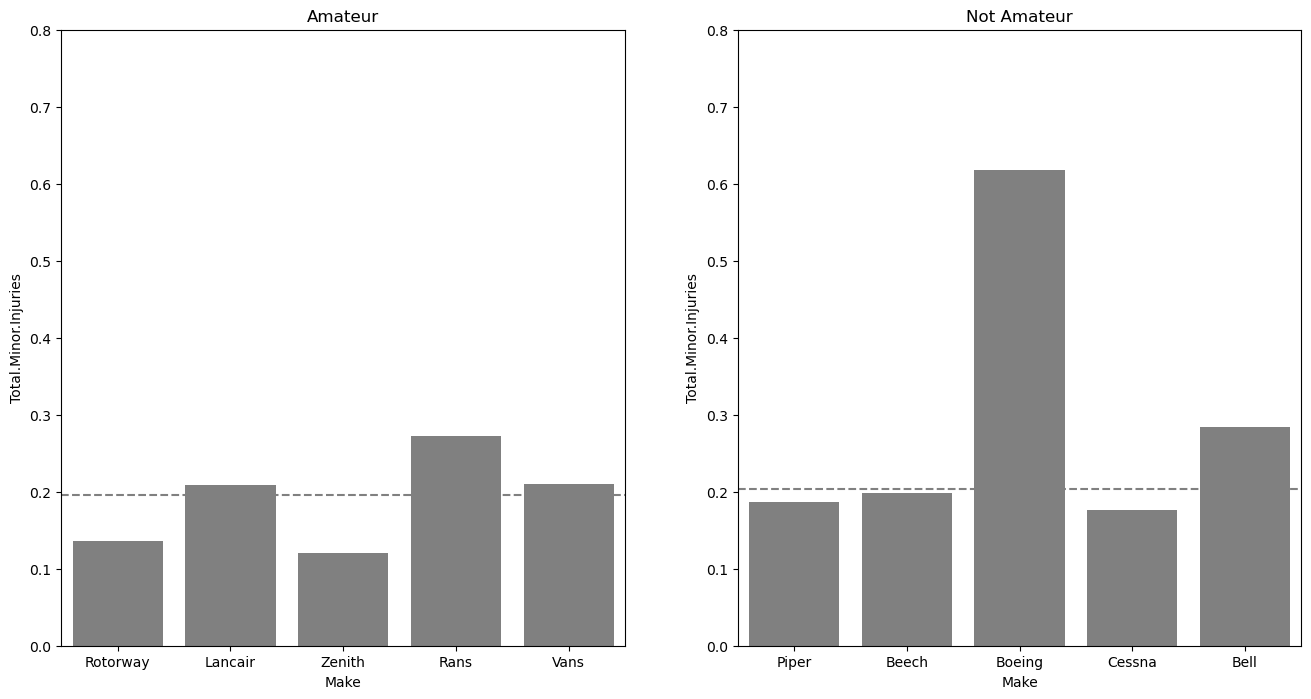

In [18]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

sns.barplot(data=top5_amateur_df, orient='v', x='Make', y='Total.Minor.Injuries', errorbar=None, estimator='mean', color='grey', ax=ax[0])
sns.barplot(data=top5_not_amateur_df, orient='v', x='Make', y='Total.Minor.Injuries', errorbar=None, estimator='mean', color='grey', ax=ax[1])

ax[0].set_ylim(0,.8)
ax[0].set_title('Amateur')
ax[0].axhline(y=top5_amateur_df['Total.Minor.Injuries'].mean(), color='grey', ls='--')

ax[1].set_ylim(0,.8)
ax[1].set_title('Not Amateur')
ax[1].axhline(y=top5_not_amateur_df['Total.Minor.Injuries'].mean(), color='grey', ls='--')

plt.show()

In both these categories, the average injury counts are about the same.

In conclusion, if the company is looking to purchase a safe, amateur built aircraft, Rotorway is the best brand by far. If the company is looking in the professionally made market, Boeing is the winner.